In [1]:
from IPython.display import Image

# 5.2 선형 판별 분석을 통한 지도 방식의 데이터 압축
선형 판별 분석(Linear Discriminant Analysis, LDA)은 규제가 없는 모델에서 차원의 저주로 인한 과대적합 정도를 줄이고 계산 효율성을 높이기 위한 특성 추출의 기법으로 사용할 수 있다.

* PCA : 데이터셋에 있는 분산이 최대인 직교 성분 축을 찾는다
* LDA : 클래스를 최적으로 구분할 수 있는 특성 부분 공간을 찾는다.

### 5.2.1 주성분 분석 vs 선형 판별 분석
* PCA와 LDA 모두 데이터셋의 차원 개수를 출 수 있는 선형 변환 기법이다.
* PCA
    * 비지도 학습
* LDA
    * 지도 학습
* LDA가 PCA보다 분류 작업에서 더 뛰어난 특성 추출 기법이다.

In [2]:
# 선형 판별 분석
# 클래스 1의 샘플은 동그라미, 클래스 2의 샘플은 덧셈 기호
Image(url='https://git.io/Jtsv8', width=400) 

x축(LD 1)으로 투영하는 선형 판별 벡터는 두 개의 정규 분포 클래스르 잘 구분. y축(LD 2)으로 투영하는 선형 판별 벡터는 데이터셋에 있는 분산을 많이 잡아내지만 클래스 판별 정보가 없기 때문에 좋은 선형 판별 벡터가 되지 못한다.

### 5.2.2 선형 판별 분석의 내부 동작 방식
1. 표준화 전처리
2. 클래스별 평균 벡터 계산
3. 클래스 간 산포 행렬 $\boldsymbol S_B$와 클래스 내 산포 행렬 $\boldsymbol S_W$
4. $\boldsymbol S_W^{-1}\boldsymbol S_B$ 행렬의 고유값
5. 고유값을 내림차순 정렬
6. 고유값이 가장 큰 k개의 고유 벡터를 선택하여 변환 행렬 $W$를 구성. 이 행렬의 열이 고유 벡터이다.
7. 변환 행렬 $W$를 사용하여 샘플을 새로운 특성 부분 공간으로 투영.

### 5.2.3 산포 행렬 계산


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

* 각 클래스에 대한 평균 벡터 계산

In [4]:
import numpy as np

np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



* 평균 벡터를 사용하여 클래스 내 산포 행렬 $S_{W}$ 계산
$\boldsymbol S_W=\sum_{i=1}^c \boldsymbol S_i$

* 이 행렬은 개별 클래스 $i$의 산포 행렬 $S_{i}$를 더해 구한다
$\boldsymbol S_i=\sum_{x\in D_i}(\boldsymbol x-\boldsymbol m_i)^T(\boldsymbol x-\boldsymbol m_i)$

In [5]:
d = 13 # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # 각 클래스에 대한 산포 행렬
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # 열 벡터를 만든다
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter # 클래스 산포 행렬을 더한다

print('클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬: 13x13


클래스가 균일하게 분포되어 있지 않기 때문에 공분산 행렬을 사용하는 것이 더 낫다.

In [6]:
print('클래스 레이블 분포: %s' % np.bincount(y_train)[1:])

클래스 레이블 분포: [41 50 33]


개별 산포 행렬 $S_{i}$를 산포 행렬 $S_{W}$로 모두 더하기 전에 스케일을 조정해야한다. 공분산 행렬은 산포 행렬의 정규화 버전이다.

$\sum_i=\dfrac{1}{n_i}\boldsymbol S_i=\dfrac{1}{n_i}\sum_{x\in D_i}(\boldsymbol x-\boldsymbol m_i)^T(\boldsymbol x-\boldsymbol m_i)$

In [7]:
d = 13  # 특성의 수
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('스케일 조정된 클래스 내의 산포 행렬: %sx%s' % (S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬: 13x13


클래스 간 산포 행렬을 계산

$\boldsymbol S_B=\sum_{i=1}^c n_i(\boldsymbol m_i-\boldsymbol m)^T(\boldsymbol m_i-\boldsymbol m)$

m은 모든 클래스의 샘플을 포함하여 계산된 전체 평균이다.

In [8]:
mean_overall = np.mean(X_train_std, axis=0)
mean_overall = mean_overall.reshape(d, 1)  # 열 벡터로 만들기
d = 13  # 특성 개수
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: %sx%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬: 13x13


### 5.2.4 새로운 특성 부분 공간을 위해 선형 판별 벡터 선택

* 공분산 행렬에 대한 고유값 분해를 수행하는 대신 행렬 $\boldsymbol S_W^{-1}\boldsymbol S_B$의 고유값 계산.

In [9]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

* 고유 벡터와 고유값 쌍으로 계산한 후 내림차순으로 고유값 정렬

In [10]:
# (고윳값, 고유벡터) 튜플의 리스트를 만듭니다.
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# (고윳값, 고유벡터) 튜플을 큰 값에서 작은 값 순서대로 정렬합니다.
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# 고윳값의 역순으로 올바르게 정렬되었는지 확인합니다.
print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

349.617808905994
172.76152218979388
5.752274263076048e-14
2.1571131987029847e-14
1.4176390454331418e-14
1.4176390454331418e-14
1.3113892875332047e-14
6.72899962596985e-15
2.7618238467023757e-15
2.7618238467023757e-15
1.6797278899409034e-15
1.2703744468254194e-15
0.0


LDA에서 선형 판별 벡터는 최대 c-1개이다. c는 클래스 레이블의 개수이다. 클래스 내 산포 행렬 $S_{B}$가 랭크 1 또는 그 이하인 c개의 행렬을 합한 것이기 때문이다. 0이 아닌 고유값이 두 개만 있는 것을 볼 수 있다.

* 공선성
    * 드물게 완벽하게 공선성을 가지는 경우(모든 샘플이 동일 선상에 위치한 경우) 공분산 행렬의 랭크는 1이다. 이때는 0이 아닌 고유값을 가진 고유 벡터가 하나만 만들어진다.

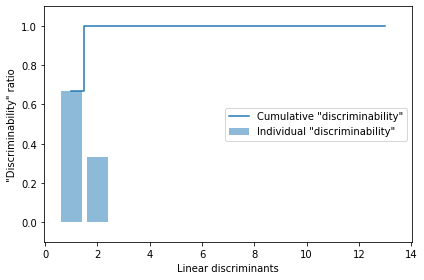

In [11]:
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

처음 두 개의 선형 판별 벡터가 Wine 데이터셋에 있는 정보 중 거의 100%를 잡아낸다.

* 두 개의 판별 고유 벡터를 열로 쌓아 변환 행렬 W를 만든다.

In [12]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', w)

행렬 W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### 5.2.5 새로운 특성 곤간으로 샘플 투영
변환 행렬 W를 훈련 데이터셋에 곱해 데이터를 변환.

$\boldsymbol X'=\boldsymbol X \boldsymbol W$


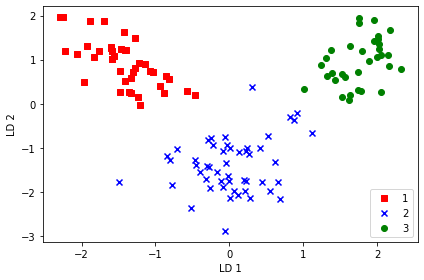

In [13]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

세 개의 와인 클래스를 새로운 특성 부분 공간에서 선형적으로 완벽하게 구분할 수 있다.

In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # 마커와 컬러맵을 준비합니다
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 클래스별로 샘플을 그립니다
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor=None if idx==1 else 'black',
                    marker=markers[idx], 
                    label=cl)

### 5.2.6 사이킷런의 LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

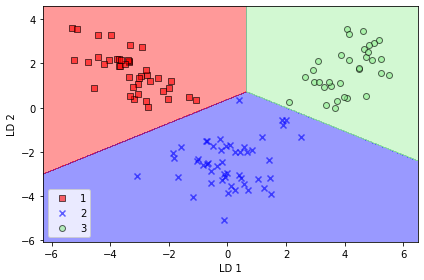

In [16]:
# LDA로 변환한 저차원 훈련 데이터셋에 로지스틱 회귀 분류
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

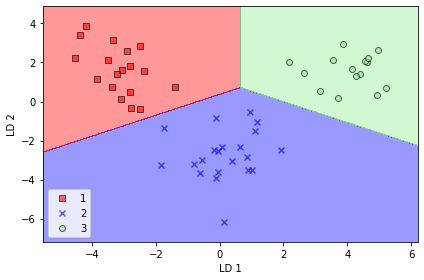

In [17]:
# 테스트 데이터셋 결과
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

#### 사이킷런의 LDA 구현 방식
* 전체 평균과 클래스별 평균 사이의 관계

    $m = \sum_{i=1}^c \frac{n_i}{n} m_i$

* 이를 클래스 내 산포 행렬 $S_{W}$에 적용하고 클래스별 산포 행렬 $S_{i}$를 클래스별 공분산 행렬 $\Sigma_i$로 정의하면 다음과 같이 쓸 수 있다.

    $S_W = \sum_{i=1}^c \frac{n_i}{n} S_i = \sum_{i=1}^c \frac{n_i}{n} \Sigma_i$

In [18]:
# 먼저 클래스 비율을 계산하고 그 다음 클래스 내 산포 행렬 계산
y_uniq, y_count = np.unique(y_train, return_counts=True)
priors = y_count / X_train_std.shape[0]
priors

array([0.3306, 0.4032, 0.2661])

In [19]:
s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    # 1/(n-1)이 아니라 1/n로 나눈 공분산 행렬을 얻기 위해 bias=True로 지정한다.
    s_w += priors[i] * np.cov(X_train_std[y_train == label].T, bias=True)

* np.cov() 함수는 공분산 행렬을 계산할 때 $\dfrac{1}{n-1}$을 곱한다. bias=True로 설정하면 $\dfrac{1}{n}$을 곱하도록 바꿀 수 있다.

    클래스 간의 산포 행렬도 클래스 비율을 곱해 계산.

    $S_B = \sum_{i=1}^{c}\frac{n_i}{n}(m_i-m)(m_i-m)^T$

In [20]:
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1].shape[0]
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

$S^{-1}_{W}S_{B}$를 직접 구해 고유값 분해를 하는 대신 scipy.linalg.eigh 함수에 $S_{B}$와 $S_{W}$를 전달하면 $S_{B}w=λS_{W}w$식의 고유값을 바로 계산할 수 있다. 계산 후 고유값 크기의 역순으로 고유 벡터를 정렬할여 최종 고유 벡터를 구한다.

In [21]:
import scipy
ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]

* LinearDiscriminantAnalysis 클래스의 결과와 같은지 확인

이 데이터셋의 클래스는 세 개이기 때문에 n_components를 설정하지 않아도 자동으로 두 개의 고유 벡터만 사용.

In [22]:
lda_eigen = LDA(solver='eigen')
lda_eigen.fit(X_train_std, y_train)

LinearDiscriminantAnalysis(solver='eigen')

In [23]:
# 클래스 내의 산포 행렬은 lda_eigen 객체의 covariance_ 속성에 저장.
np.allclose(s_w, lda_eigen.covariance_)

True

* 클래스 간의 산포 행렬은 따로 제공되지는 않지만 총 산포 행렬(total scatter matrix) $S_T$에서 클래스 내 산포 행렬 $S_W$를 빼서 구할 수 있다.

    $\boldsymbol S_B = \boldsymbol S_T - \boldsymbol S_W$

In [24]:
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
np.allclose(Sb, s_b)

True

* 구해진 고유 벡터는 scalings_ 속성에 저장되어 있다. 클래스가 3개 이므로 두 개의 고유 벡터(선형 판별 벡터)를 비교

In [25]:
np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2])

True

* transform 메서드는 단순히 샘플와 고유 벡터의 점곱으로 구현할 수 있다

In [26]:
np.allclose(lda_eigen.transform(X_test_std), np.dot(X_test_std, ei_vec[:, :2]))

True

LinearDiscriminantAnalysis 클래스의 solver 매개변수 기본값은 'svd'로 특이 값 분해를 사용. 산포 행렬을 직접 계산하지 않기 때문에 특성이 많은 데이터셋에도 잘 작동한다.